In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt
from matplotlib import ticker
import matplotlib.cm as cm
from matplotlib import colors
import scipy.stats
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import matplotlib.gridspec as gridspec
import random
import matplotlib
import sys
# %matplotlib inline
sys.path += ['../scripts/']

# import labornet_original as lbn
import labornet as lbn

# Aggregate level

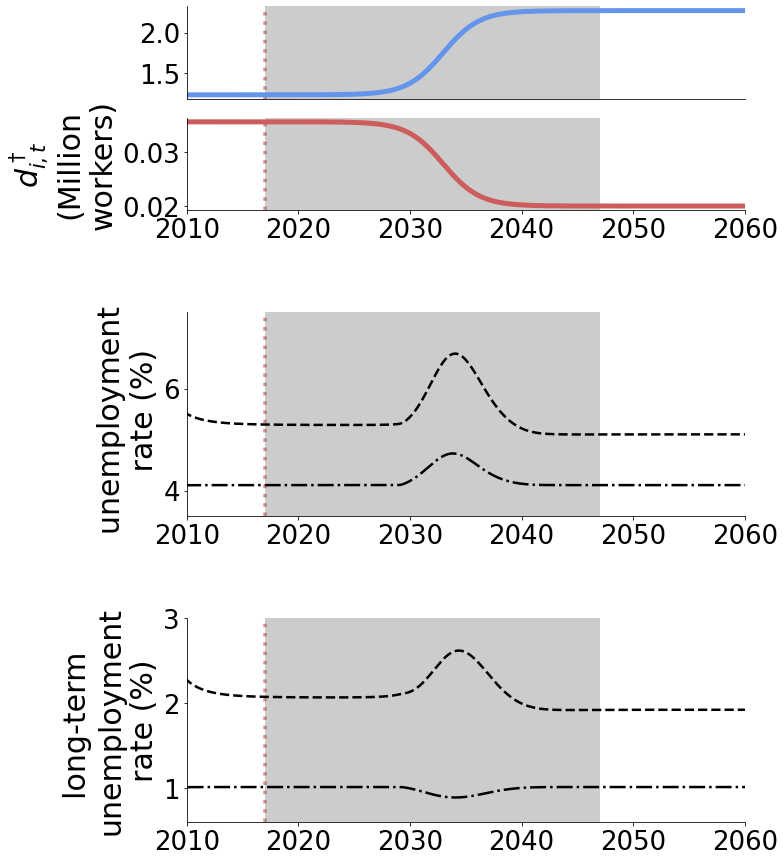

In [3]:
#### Plotting details
#### Plotting details
figsize_ = (10,10)
fontsize_ticks = 26#16
fontsize_axis = 30#34#26
fontsize_title = 28
fontsize_legend = 20
linewidth_ = 3.5
linewidth_thin = 2.5
plot_simulations = False#False
plot_sharp_transition =False#True

path_exp_sim = "../results/simulations/"
path_exp_numerics = "../results/csv/"
path_exp_num = "../results/csv/"
path_label = "../data/"
path_data = "../data/"
path_exp_fig = "../results/fig/"

# details of the simulation, so far hand copied
matrix_omn = "OMN"#"kn"#"JS"#"OMN"#"OMN" #"kn"#"OMN"
matrix_kn = "kn"#"kn"#"JS"#"OMN"#"OMN" #"kn"#"OMN"

color_omn = "#004D40"
color_kn = "#D81B60"
color_retrained = "#513e5c"
color_reshedges = "#FFC107"
color_reshweight = "#1E88E5"
color_retrained_random = "#1E88E5"

n_dif_sim = 10
t_sim = 600#600 # total simulation time
t_simulation = 600
t_shock = 100#100

# parameters
δ_u = 0.0160001
δ_v = 0.012001
# δ_v = δ_u
γ_u = 10*δ_u
γ_v = γ_u
τ = 3#7#6#5

#defining the shock
shock = "FO_automation"
# shock = "SMLautomation"
# shock = "FO_automation_095"
# shock = "FO_automation_105"
# shock = "SMLautomation_095"
# shock = "SMLautomation_105"
# shock = "FO_automation_reshuffled_rand"
# shock = "FO_automation_reshuffled_clustered"

shock_duration_years = 30
timestep_duration = 27/τ
shock_duration_timesteps = round(shock_duration_years*52 /timestep_duration)
# defining number of agents used 0.001 ~ 150k agents, 0.01 ~ 1.5M agents

# fraction of labor force with which sim and num are run
diminishing_factor = 1.0#0.01#1.0
diminishing_factor_kn = 1.0#0.1#1.0#0.1
diminishing_factor_sim = 0.01

### variables exclusive for dim
# period to measure changes in
t_transition_start = int(t_shock + 0*shock_duration_timesteps)
t_transition_end = int(t_shock + 1*shock_duration_timesteps)

# name csv with parameter names
parameter_names = "_deltau" + str(δ_u)[3:6] + "v" + str(δ_v)[3:6] + \
    "gamma" + str(γ_u)[2:5] + "_tau" + str(round(τ)) + "_shockduration" + \
    str(shock_duration_years) + "_dimfact" + str(diminishing_factor)[2:]

# TODO homogenize shockduration/yearauto for num and sim
parameter_names_sim = "_deltau" + str(δ_u)[3:6] + "v" + str(δ_v)[3:6] + \
        "gamma" + str(γ_u)[2:5] + "_tau" + str(round(τ +1)) + "_shockduration" + \
        str(shock_duration_years) + "_dimfact" + str(diminishing_factor_sim)[2:]


# getting file name for omn and kn
import_name_num = matrix_omn + shock + parameter_names +  ".csv"
import_name_sim = matrix_omn + shock + parameter_names_sim +  ".csv"

# same but for complete network
import_name_num_kn = matrix_kn + shock + parameter_names + ".csv"
import_name_sim_kn = matrix_omn + shock + parameter_names_sim +  ".csv"

def make_df_num_array(matrix, shock, parameter_names):
    """ returns data frames of numerical solution of unemp, emp,
    longterm unemp and target demand
    """
    df_num_u = pd.read_csv(path_exp_numerics + "u_per_occ_num" + matrix\
                    + shock + parameter_names +  ".csv")
    df_num_e = pd.read_csv(path_exp_numerics + "e_per_occ_num" + matrix\
                    + shock + parameter_names +  ".csv")
    df_num_ltu = pd.read_csv(path_exp_numerics + "ltu_per_occ_num" + matrix\
                    + shock + parameter_names +  ".csv")
    df_num_ddagger = pd.read_csv(path_exp_numerics + "ddagger_per_occ_num" + \
                    matrix + shock + parameter_names +  ".csv")
    return df_num_u, df_num_e, df_num_ltu, df_num_ddagger

def make_u_ltu_rates(df_num_u, df_num_e, df_num_ltu):
    un = np.array(df_num_u.iloc[:,3:])
    en = np.array(df_num_e.iloc[:,3:])
    ltun= np.array(df_num_ltu.iloc[:,3:])
    u_total_num = un.sum(axis=0)
    e_total_num = en.sum(axis=0)
    ltu_total_num = ltun.sum(axis=0)
    n_agents_num = un.sum(axis=0)[0] + en.sum(axis=0)[0]

    u_rate = 100*u_total_num/ n_agents_num
    ltu_rate = 100*ltu_total_num/ n_agents_num
    return u_rate, ltu_rate

def make_u_ltu_rates_occ(occ, df_num_u, df_num_e, df_num_ltu):
    un = np.array(df_num_u.iloc[occ,3:])
    en = np.array(df_num_e.iloc[occ,3:])
    ltun = np.array(df_num_ltu.iloc[occ,3:])
    n_agents_num = un + en
    u_rate = 100*un/ n_agents_num
    ltu_rate = 100*ltun/ n_agents_num
    return u_rate, ltu_rate


def make_simulations_df(n_dif_sim, matrix, shock, parameter_names):
    """making list of data frames of simulations
    """
    # list of dataframes
    df_sim_u_list = []
    df_sim_v_list = []
    df_sim_e_list = []
    df_sim_ltu_list = []

    import_sim_name = matrix + shock + parameter_names +  ".csv"

    for s in range(1,n_dif_sim + 1):
        u_sim_occ_name = "u_per_occ_sim" + str(s) + import_sim_name
        v_sim_occ_name = "v_per_occ_sim" + str(s) + import_sim_name
        e_sim_occ_name = "e_per_occ_sim" + str(s)+ import_sim_name
        ltu_sim_occ_name = "ltu_per_occ_sim"+ str(s) + import_sim_name

        df_sim_u = pd.read_csv(path_exp_sim + u_sim_occ_name)
        df_sim_v = pd.read_csv(path_exp_sim + v_sim_occ_name)
        df_sim_e = pd.read_csv(path_exp_sim + e_sim_occ_name)
        df_sim_ltu = pd.read_csv(path_exp_sim + ltu_sim_occ_name)

        df_sim_u_list.append(df_sim_u)
        df_sim_v_list.append(df_sim_v)
        df_sim_e_list.append(df_sim_e)
        df_sim_ltu_list.append(df_sim_ltu)

    return df_sim_u_list, df_sim_v_list, df_sim_e_list, df_sim_ltu_list



df_num_u_omn, df_num_e_omn, df_num_ltu_omn, df_num_ddagger_omn = \
        make_df_num_array("OMN", shock, parameter_names)
u_omn, ltu_omn = make_u_ltu_rates(df_num_u_omn, df_num_e_omn, df_num_ltu_omn)

df_num_u_kn, df_num_e_kn, df_num_ltu_kn, df_num_ddagger_kn = \
        make_df_num_array("kn", shock, parameter_names)
u_kn, ltu_kn = make_u_ltu_rates(df_num_u_kn, df_num_e_kn, df_num_ltu_kn)


if plot_simulations:
    df_sim_u_list_omn, df_sim_v_list_omn, df_sim_e_list_omn, \
        df_sim_ltu_list_omn = make_simulations_df(n_dif_sim, "OMN", shock, \
                                parameter_names_sim)

    df_sim_u_list_kn, df_sim_v_list_kn, df_sim_e_list_kn, \
        df_sim_ltu_list_kn = make_simulations_df(n_dif_sim, "kn", shock, \
                                parameter_names_sim)


# just to choose some initial occupations
random.seed(1) # for reproducibility NOTE maybe remove? not sure if needed

occupations_to_plot = [183, 234] # [0, 230, 154, 301, 234]
occupations_to_plot_ind = [0, 230, 154, 301, 234] # [0, 230, 154, 301, 234]
timestep_duration = 27/(τ + 1)
shock_duration_timesteps = round(shock_duration_years*52 /timestep_duration)

time_scale_year = (27/(τ + 1))/52 #5.4 week over 52 weeks that are a year
starting_time = 2005
time_array = starting_time  + time_scale_year * np.array([i for i in range(t_simulation)])

# t_transition_start = int(t_shock +0*shock_duration_timesteps)
# t_transition_end = int(t_shock + 1*shock_duration_timesteps)
t_transition_start = starting_time  + int(t_shock*time_scale_year + 0*shock_duration_timesteps*time_scale_year)
t_transition_end = starting_time  +  int(t_shock*time_scale_year + 1*shock_duration_timesteps*time_scale_year)


if shock[0:13] == "FO_automation":
    occupations_to_plot = [298, 234]
    occupations_to_plot = [282, 319]
    occupations_to_plot = [183, 234]
elif shock[0:13] == "SMLautomation":
    occupations_to_plot = [298, 218]

##### Plot aggregate rates and demand

f = plt.figure(figsize=(10,15))
# f = plt.figure(figsize=(14,10))
f.subplots_adjust(hspace=0.5)
gs = gridspec.GridSpec(3, 1,height_ratios=[1,1,1])
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0], hspace=0.2)
ax0 = plt.subplot(gs00[0])
ax1 = plt.subplot(gs00[1], sharex=ax0)
ax2 = plt.subplot(gs[1], sharex=ax0)
ax3 = plt.subplot(gs[2], sharex=ax0)

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax1.tick_params(labelsize=fontsize_ticks)
ax2.tick_params(labelsize=fontsize_ticks)
ax0.tick_params(labelsize=fontsize_ticks)
ax3.tick_params(labelsize=fontsize_ticks)
#### Plotting demand
ax0.set_xlim([2010,2060])
ax0.axvline(x=int(starting_time  + time_scale_year * t_shock), linestyle=":", linewidth=linewidth_,color="brown", alpha=0.5, label="Automation starts")
if plot_sharp_transition:
        ax0.axvspan(t_transition_start + 0.25*shock_duration_years, t_transition_end - 0.25*shock_duration_years, facecolor='coral', alpha=0.5)

ax0.axvspan(t_transition_start, t_transition_end, facecolor='grey', alpha=0.4)
colors = ["indianred", "cornflowerblue", "b"]
ddagn = np.array(df_num_ddagger_omn.iloc[occupations_to_plot[1],3:])
# divide over diminishing_factor*million to have totalmillion of agents
ax0.plot(time_array, ddagn / (diminishing_factor*1e6), color=colors[1], linewidth=5 )
# ax0.set_ylabel(r'$d^\dagger_{i,t}$'+"\n(Million\nworkers)",fontsize=fontsize_axis)#, rotation=0)
ax0.set_xlim([2005,2050])
ax0.axes.get_xaxis().set_visible(False)

ax1.set_xlim([2010,2060])
ax1.set_ylabel("target demand \n(M of workers)", fontsize=fontsize_axis)
ax1.axvline(x=int(starting_time  + time_scale_year * t_shock), linestyle=":", linewidth=linewidth_,color="brown", alpha=0.5, label="Automation starts")
if plot_sharp_transition:
        ax0.axvspan(t_transition_start + 0.25*shock_duration_years, t_transition_end - 0.25*shock_duration_years, facecolor='coral', alpha=0.5)
ax1.axvspan(t_transition_start, t_transition_end, facecolor='grey', alpha=0.4)

ddagn = np.array(df_num_ddagger_omn.iloc[occupations_to_plot[0],3:])
ax1.plot(time_array, ddagn / (diminishing_factor*1e6), color=colors[0], linewidth=5 )
ax1.set_ylabel(r'$d^\dagger_{i,t}$'+"\n(Million\nworkers)",fontsize=fontsize_axis)#, rotation=0)
ax1.set_xlim([2005,2050])
ax1.set_title(" ",fontsize=fontsize_title)

### Plotting unemployment
average_u = np.zeros(t_sim)
average_u_kn = np.zeros(t_sim)
if plot_simulations:
    for s in range(n_dif_sim):
        df_us = df_sim_u_list_omn[s]
        df_es = df_sim_e_list_omn[s]
        us = np.array(df_us.iloc[:,3:])
        es = np.array(df_es.iloc[:,3:])
        u_total_sim = us.sum(axis=0)
        e_total_sim = es.sum(axis=0)
        n_agents = es.sum(axis=0)[0] + us.sum(axis=0)[0]
        average_u = average_u + u_total_sim / n_agents
        ax2.plot(time_array, 100*u_total_sim  /  n_agents,linewidth=linewidth_, color=color_omn, alpha=0.2)

        df_us_kn = df_sim_u_list_kn[s]
        df_es_kn = df_sim_u_list_kn[s]

        us_kn = np.array(df_us_kn.iloc[:,3:])
        es_kn = np.array(df_es_kn.iloc[:,3:])
        u_total_sim_kn = us_kn.sum(axis=0)
        e_total_sim_kn = es_kn.sum(axis=0)
        n_agents = es.sum(axis=0)[0] + us.sum(axis=0)[0]
        average_u_kn = average_u_kn + u_total_sim_kn / n_agents
        ax2.set_xlim([2005,2035])
        ax2.plot(time_array, 100*u_total_sim_kn  /  n_agents,linewidth=linewidth_, color =color_kn, alpha=0.2)
    print("L = " , n_agents)
    # average_u_kn = average_u_kn / n_dif_sim
    # ax1.plot(time_array, 100*average_u_kn, "-",color="red",linewidth=linewidth_, label="No network, simulations\naverage")

# average_u = average_u / n_dif_sim
# ax1.plot(time_array, 100*average_u, "-",color="limegreen",linewidth=linewidth_, label="Network, simulations")

######### Numerical
ax2.plot(time_array, u_omn , "--", color="k", linewidth=linewidth_thin,label="Network, analytical")
ax2.plot(time_array, u_kn , "-.",linewidth=linewidth_thin,  color="k", label="Complete network, numerical\nsolution")

#ax1.set_ylim([4, 5])
ax2.axvline(x=int(starting_time  + time_scale_year * t_shock), linestyle=":", linewidth=linewidth_,color="brown", alpha=0.5, label="Automation starts")
if plot_sharp_transition:
        ax1.axvspan(t_transition_start + 0.25*shock_duration_years, t_transition_end - 0.25*shock_duration_years, facecolor='coral', alpha=0.5)
ax2.axvspan(t_transition_start, t_transition_end, facecolor='grey', alpha=0.4)
ax2.set_xlim([2010,2060])
ax2.set_ylabel("unemployment \n rate (%)", fontsize=fontsize_axis)
ax2.set_ylim([4.5, 7.5])
ax2.set_ylim([3.5, 7.5])
if shock[13:] == "_095":
    ax2.set_ylim([4.5, 10])
elif shock[13:] == "_105":
    ax2.set_ylim([2, 7.1])

# Plot longterm unemployment
average_ltu = np.zeros(t_sim)
average_ltu_kn = np.zeros(t_sim)
# simulations
if plot_simulations:
    for s in range(n_dif_sim):
        df_us = df_sim_u_list_omn[s]
        df_ltus = df_sim_ltu_list_omn[s]
        df_es = df_sim_e_list_omn[s]
        us = np.array(df_us.iloc[:,3:])
        es = np.array(df_es.iloc[:,3:])
        ltus = np.array(df_ltus.iloc[:,3:])
        u_total_sim = us.sum(axis=0)
        e_total_sim = es.sum(axis=0)
        ltu_total_sim = ltus.sum(axis=0)
        n_agents = es.sum(axis=0)[0] + us.sum(axis=0)[0]
        average_ltu = average_ltu + ltu_total_sim / n_agents
        ax3.plot(time_array, 100*ltu_total_sim /  n_agents,linewidth=linewidth_, color = "#004D40", alpha=0.3)

        df_us_kn = df_sim_u_list_kn[s]
        df_ltus_kn = df_sim_ltu_list_kn[s]
        df_es_kn = df_sim_e_list_kn[s]
        us_kn = np.array(df_us_kn.iloc[:,3:])
        es_kn = np.array(df_es_kn.iloc[:,3:])
        ltus_kn = np.array(df_ltus_kn.iloc[:,3:])
        u_total_sim_kn = us_kn.sum(axis=0)
        e_total_sim_kn = es_kn.sum(axis=0)
        ltu_total_sim_kn = ltus_kn.sum(axis=0)
        n_agents = es.sum(axis=0)[0] + us.sum(axis=0)[0]
        average_ltu_kn = average_ltu_kn + ltu_total_sim_kn / n_agents
        ax3.plot(time_array, 100*ltu_total_sim_kn /  n_agents,linewidth=linewidth_, color = "#D81B60", alpha=0.3)
    average_ltu_kn = average_ltu_kn / n_dif_sim
    # ax2.plot(time_array, 100*average_ltu_kn, "-",color="red" ,linewidth=linewidth_,label="No network, simulations\naverage")
    #
    # average_ltu = average_ltu / n_dif_sim
    # ax2.plot(time_array, 100*average_ltu, "-",color="limegreen" , linewidth=linewidth_, label="Network, simulations")

###### Numerical

ax3.plot(time_array, ltu_omn, "--", linewidth=linewidth_thin, color="k",label="Network, analytical")
ax3.plot(time_array, ltu_kn, "-.", linewidth=linewidth_thin,color="k", label="No Network, numerical\nsolution")
ax3.axvline(x=int(starting_time  + time_scale_year * t_shock), linestyle=":", linewidth=linewidth_,color="brown", alpha=0.5, label="Automation starts")
if plot_sharp_transition:
        ax2.axvspan(t_transition_start + 0.25*shock_duration_years, t_transition_end - 0.25*shock_duration_years, facecolor='coral', alpha=0.5)
ax3.axvspan(t_transition_start, t_transition_end, facecolor='grey', alpha=0.4)
ax3.set_ylim([0.6, 3.0])
ax3.set_xlim([2010,2060])
if shock[13:] == "_095":
    ax3.set_ylim([0.6, 6.0])
elif shock[13:] == "_105":
    ax3.set_ylim([0.0, 3.0])
ax3.set_ylabel("long-term \nunemployment\nrate (%)", fontsize=fontsize_axis)
# if plot_sharp_transition:
#
#         plt.savefig(path_local+path_exp_fig+"Unemployment_demand_simvsnum"+ shock + "duration" +str(shock_duration_years) +"params"+ parameters_names +"OMN_sharp_v2.svg", bbox_inches="tight")
#         plt.savefig(path_local+path_exp_fig+"Unemployment_demand_simvsnum"+ shock + "duration" +str(shock_duration_years) +"params"+ parameters_names +"OMN_sharp_v2.png", bbox_inches="tight")
# if plot_simulations:
#         plt.savefig(path_exp_fig+"Unemployment_demand_simvsnum"+ shock + "duration" +str(shock_duration_years) +"params"+ parameter_names +"OMN.svg", bbox_inches="tight")
#         plt.savefig(path_exp_fig+"Unemployment_demand_simvsnum"+ shock + "duration" +str(shock_duration_years) +"params"+ parameter_names +"OMN.png", bbox_inches="tight")
plt.show()


In [4]:

print("pre shock steady state unemp OMN ", round(u_omn[t_shock], 1))
print("pre shock steady state unemp kn ", round(u_kn[t_shock], 1))
print("rel diff between OMN and KN = ", (u_omn[t_shock] - u_kn[t_shock])/u_kn[t_shock])
# print("rel diff between OMN and KN = ", (5.3 - 4.1)/4.1)
print("spike unemp OMN ", round(max(u_omn), 1))
print("spike unemp kn ", round(max(u_kn), 1))
print("relative dif = ", (max(u_omn) -u_omn[t_shock])/u_omn[t_shock]  )
print("pre shock steady longterm unemp state OMN ", round(ltu_omn[t_shock], 1))
print("pre shock steady longterm unemp state kn ", round(ltu_kn[t_shock], 1))
print("spike longterm unemp OMN ", round(max(ltu_omn), 1))
print("spike longterm unemp kn ", round(max(ltu_kn), 1))
print("relative dif = ", (max(ltu_omn) -ltu_omn[t_shock])/ltu_omn[t_shock]  )
print("post shock steady state unemp omn ",  u_omn[-1])
print("pre psot shock unemp difference unemp omn " , (u_omn[t_shock] -  u_omn[-1]))

pre shock steady state unemp OMN  5.3
pre shock steady state unemp kn  4.1
rel diff between OMN and KN =  0.28879301303466903
spike unemp OMN  12.2
spike unemp kn  4.7
relative dif =  1.2974288758851313
pre shock steady longterm unemp state OMN  2.1
pre shock steady longterm unemp state kn  1.0
spike longterm unemp OMN  4.0
spike longterm unemp kn  1.0
relative dif =  0.9557218081952455
post shock steady state unemp omn  5.102850834855484
pre psot shock unemp difference unemp omn  0.18967122037452455


# Long term

In [5]:
#### Plotting details
figsize_ = (10,10)
figsize_ = (18,10)
fontsize_ticks = 32#16
fontsize_axis = 40#26
fontsize_title = 28
fontsize_legend = 16
linewidth_ = 4
plot_kn = True
plot_score = True

ipums_employment2016 = "ipums_employment_2016.csv"
df_labs_emp = pd.read_csv(path_data+ipums_employment2016)
employment = np.array(df_labs_emp["IPUMS_CPS_av_monthly_employment_whole_period"])


###
# adding information on employment 2016
###
t_shock = 100 # time at which shock starts
t_simulation = 600
shock_duration_years = 30
diminishing_factor = 1.0

size_emp = [35 + 0.0002*(employment[i]) for i in range(len(employment))]

parameter_names = "_deltau" + str(δ_u)[3:6] + "v" + str(δ_v)[3:6] + \
    "gamma" + str(γ_u)[2:5] + "_tau" + str(round(τ)) + "_shockduration" + \
    str(shock_duration_years) + "_dimfact" + str(diminishing_factor)[2:]


df_omn = pd.read_csv(path_exp_num + "u_ltu_perc_change" + "OMN" + shock\
                + parameter_names+ ".csv")

df_kn = pd.read_csv(path_exp_num + "u_ltu_perc_change" + "kn" + shock\
                + parameter_names+ ".csv")

ipums_lab_file = "ipums_variables.csv"
ipums_mSML = "ipums_labs_mSML_manual.csv"
df_labs = pd.read_csv(path_data + ipums_lab_file)
df_labs = pd.read_csv(path_data + ipums_lab_file)
df_sml = pd.read_csv(path_data + ipums_mSML)
median_wage = np.array(df_labs["median_earnings"])
wage = np.array(df_labs["log_median_earnings"])
if shock == "FO_automation":
    p = np.array(df_labs["auto_prob_average"])
elif shock == "SMLautomation":
    p = np.array(df_sml['mSML'])/5

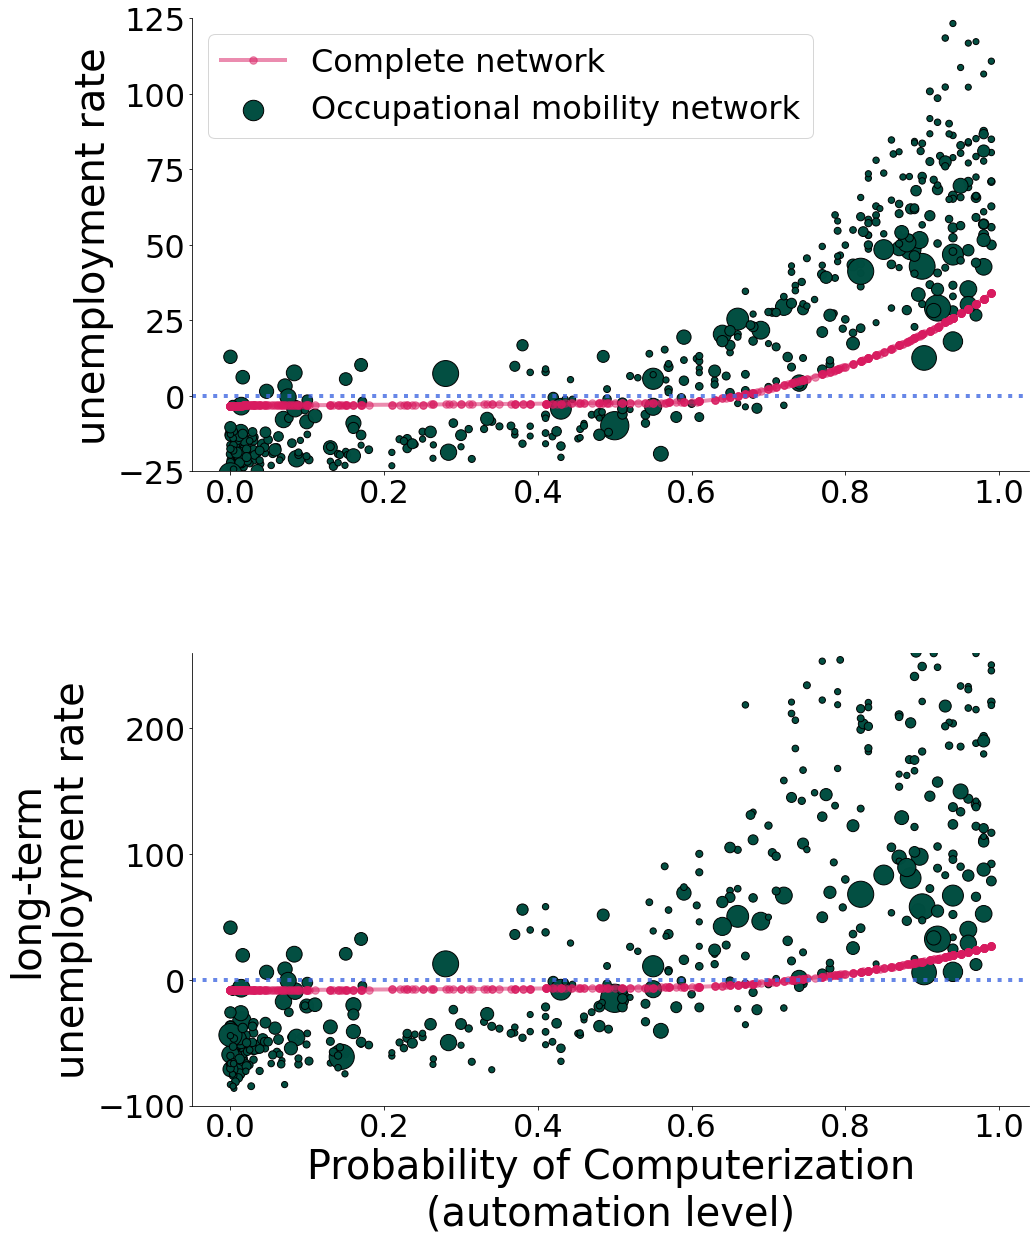

In [6]:
# getting array for OMN to plot
array_of_plot_u = np.array(df_omn["u_perc_change"])
array_of_plot_ltu = np.array(df_omn["ltu_perc_change"])
array_of_plot_u_kn = np.array(df_kn["u_perc_change"])
array_of_plot_ltu_kn = np.array(df_kn["ltu_perc_change"])

size_emp = [35 + 0.0002*(employment[i]) for i in range(len(employment))]

if shock[0:3] == "FO_":
    array_x_axis = p
    ticks = [str(i/10) for i in range(-1,11)]
    n_ticks = 22
    xlabel_title = "Probability of automatability"
    x_ref = "auto_prob_average_manual"
elif shock[0:3] == "SML":
    n_ticks = 45
    array_x_axis = p
    if plot_score:
            array_x_axis = p
            split = max(array_x_axis) - min(array_x_axis)
            ticks = [str(round( min(array_x_axis) + i*split/10, 2)) for i in range(-1,11)]
            xlabel_title = "Suitability for Machine Learning"
            x_ref = "mSML"


f = plt.figure(figsize=(15,20))
f.subplots_adjust(hspace=0.4)
gs = gridspec.GridSpec(2, 1,height_ratios=[1, 1])
ax2 = plt.subplot(gs[1])
ax1 = plt.subplot(gs[0], sharex=ax2)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelsize=fontsize_ticks)
ax2.tick_params(labelsize=fontsize_ticks)
if shock[:3] == "FO_":
        pass
else:
        ax1.set_ylim([-15,15])
        ax2.set_ylim([-40,40])
        ax2.set_xlim([3.1, 3.9])
        if plot_score:
                ax2.set_xlim([3.1/5, 3.9/5])
# plotting unemployment change stuff
ax1.scatter(array_x_axis, array_of_plot_u, s=size_emp, edgecolors='k', \
        alpha=0.99, label="Occupational mobility network", c=color_omn)

arr1inds = array_x_axis.argsort()
sorted_arr1 = array_x_axis[arr1inds[::-1]]
sorted_arr2 = array_of_plot_u_kn[arr1inds[::-1]]
ax1.plot(sorted_arr1, sorted_arr2, ".-", alpha=0.5, linewidth=4, markersize=15, color=color_kn, label="Complete network")
ax1.axhline(y=0, linestyle=":", linewidth=linewidth_,color="royalblue", alpha=0.8)
ax1.set_ylim([-25, 125])
# plotting longterm unemployment change
# plotting OMN stuff

ax2.scatter(array_x_axis, array_of_plot_ltu, s=size_emp, edgecolors='k', \
        alpha=0.99, label="Network structure", c=color_omn)

arr1inds = array_x_axis.argsort()
sorted_arr1 = array_x_axis[arr1inds[::-1]]
sorted_arr2 = array_of_plot_ltu_kn[arr1inds[::-1]]
ax2.plot(sorted_arr1, sorted_arr2, ".-", alpha=0.5, linewidth=4, markersize=15, color=color_kn, label="No network \nstructure")
ax2.axhline(y=0, linestyle=":", linewidth=linewidth_,color="royalblue", alpha=0.8)
ax2.set_ylim([-100, 260])
if shock[:3] == "FO_":
        ax1.legend(loc=2, fontsize=32)
        ax2.set_xlabel("Probability of Computerization\n(automation level)", fontsize=fontsize_axis)
        ax1.set_ylabel("unemployment rate", fontsize=fontsize_axis)
        ax2.set_ylabel("long-term\nunemployment rate", fontsize=fontsize_axis)
else:
        ax2.set_xlabel("Suitability for Machine Learning score\n(automation level)", fontsize=fontsize_axis)
# plt.savefig(path_exp_fig+ shock \
#            +  "ltu_and_u"+ parameter_names +".png", bbox_inches="tight")
# plt.savefig(path_exp_fig+ shock \
#            +  "ltu_and_u"+ parameter_names +".svg", bbox_inches="tight")
plt.show()


## wage

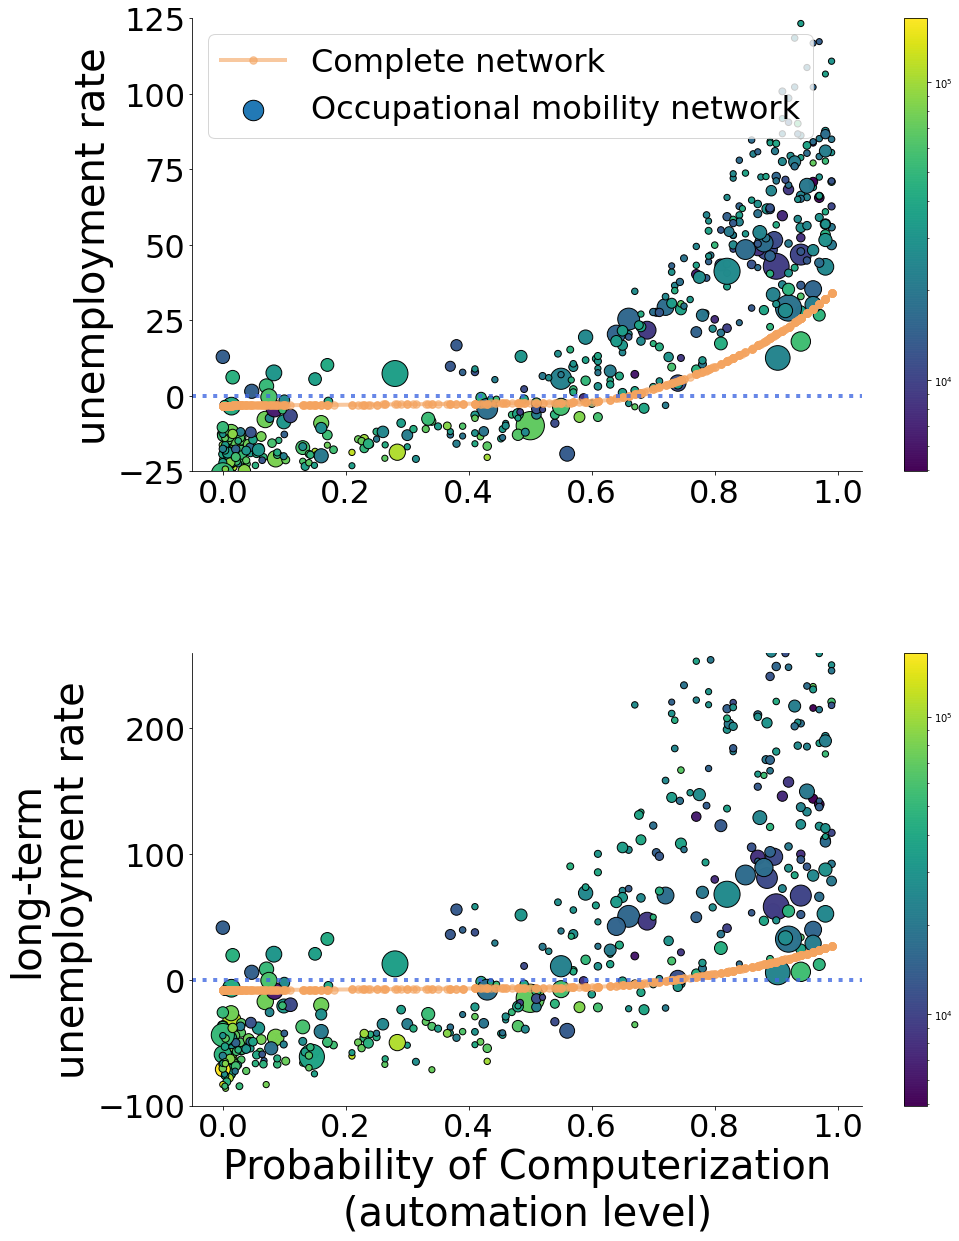

In [7]:

####
# Standard with wage
####

color_kn = "sandybrown"#"darkorange"

f = plt.figure(figsize=(15,20))
f.subplots_adjust(hspace=0.4)
gs = gridspec.GridSpec(2, 1,height_ratios=[1, 1])
ax2 = plt.subplot(gs[1])
ax1 = plt.subplot(gs[0], sharex=ax2)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelsize=fontsize_ticks)
ax2.tick_params(labelsize=fontsize_ticks)
if shock[:3] == "FO_":
        pass
else:
        ax1.set_ylim([-15,15])
        ax2.set_ylim([-40,40])
        ax2.set_xlim([3.1, 3.9])
        if plot_score:
                ax2.set_xlim([3.1/5, 3.9/5])
# plotting unemployment change stuff
u_plot =ax1.scatter(array_x_axis, array_of_plot_u, s=size_emp, edgecolors='k', \
        alpha=0.99, label="Occupational mobility network", c=median_wage,    cmap="viridis", norm=matplotlib.colors.LogNorm())

arr1inds = array_x_axis.argsort()
sorted_arr1 = array_x_axis[arr1inds[::-1]]
sorted_arr2 = array_of_plot_u_kn[arr1inds[::-1]]
ax1.plot(sorted_arr1, sorted_arr2, ".-", alpha=0.6, linewidth=4, markersize=15, color=color_kn, label="Complete network")
ax1.axhline(y=0, linestyle=":", linewidth=linewidth_,color="royalblue", alpha=0.8)
ax1.set_ylim([-25, 125])
# plotting longterm unemployment change
# plotting OMN stuff

ltu_plot =ax2.scatter(array_x_axis, array_of_plot_ltu, s=size_emp, edgecolors='k', \
        alpha=0.99, label="Network structure", c=median_wage,    cmap="viridis", norm=matplotlib.colors.LogNorm())

arr1inds = array_x_axis.argsort()
sorted_arr1 = array_x_axis[arr1inds[::-1]]
sorted_arr2 = array_of_plot_ltu_kn[arr1inds[::-1]]
ax2.plot(sorted_arr1, sorted_arr2, ".-", alpha=0.6, linewidth=4, markersize=15, color=color_kn, label="No network \nstructure")
ax2.axhline(y=0, linestyle=":", linewidth=linewidth_,color="royalblue", alpha=0.8)
ax2.set_ylim([-100, 260])
plt.colorbar(u_plot,ax=ax1)
plt.colorbar(ltu_plot,ax=ax2)
if shock[:3] == "FO_":
        ax1.legend(loc=2, fontsize=32)
        ax2.set_xlabel("Probability of Computerization\n(automation level)", fontsize=fontsize_axis)
        ax1.set_ylabel("unemployment rate", fontsize=fontsize_axis)
        ax2.set_ylabel("long-term\nunemployment rate", fontsize=fontsize_axis)
else:
        ax2.set_xlabel("Suitability for Machine Learning score\n(automation level)", fontsize=fontsize_axis)
# plt.savefig(path_exp_fig+ shock \
#            +  "ltu_and_u"+ parameter_names +"wagecolor.png", bbox_inches="tight")
# plt.savefig(path_exp_fig+ shock \
#            +  "ltu_and_u"+ parameter_names +"wagecolor.svg", bbox_inches="tight")
plt.show()



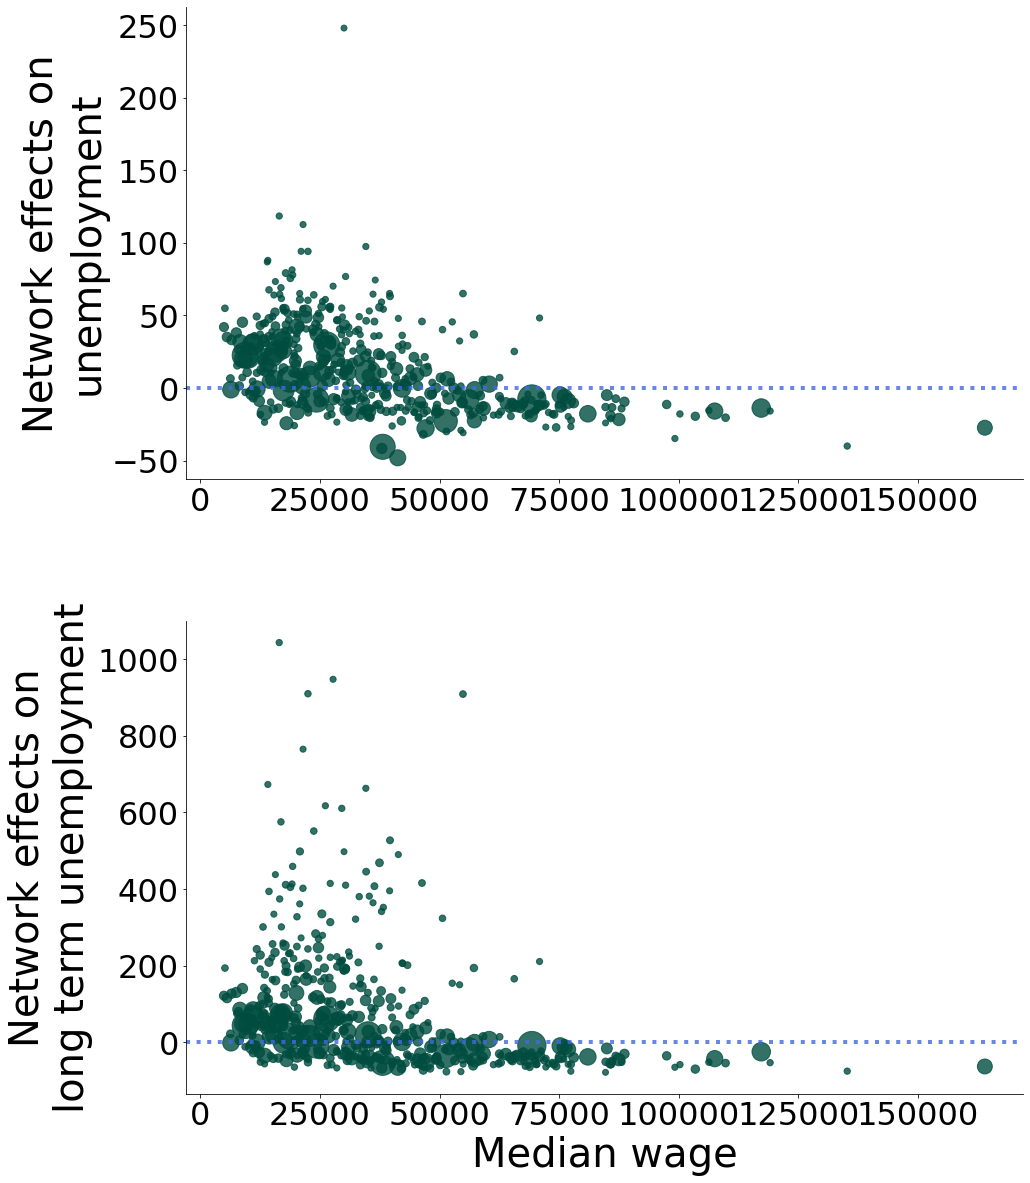

In [8]:

#######
# wage plots
########

len(median_wage[p <= 0.5])

# get index of an occupation with ~0.5 automation probability
idx_05 = np.abs(p-0.5).argmin()
ltu_less05 = array_of_plot_ltu_kn[idx_05 ]
ltu_less05
mean_medianwage_noauto = np.mean(median_wage[p <= 0.5])
mean_medianwage_noauto

np.mean(median_wage[np.logical_and(p<=0.5, array_of_plot_ltu < ltu_less05)])
np.mean(median_wage[np.logical_and(p<=0.5, array_of_plot_ltu > ltu_less05)])


scipy.stats.pearsonr(median_wage, array_of_plot_ltu -  array_of_plot_ltu_kn)

f = plt.figure(figsize=(15,20))
f.subplots_adjust(hspace=0.3)
gs = gridspec.GridSpec(2, 1,height_ratios=[1, 1])
ax2 = plt.subplot(gs[1])
ax1 = plt.subplot(gs[0], sharex=ax2)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelsize=fontsize_ticks)
ax2.tick_params(labelsize=fontsize_ticks)
ax1.scatter(median_wage, array_of_plot_u -  array_of_plot_u_kn, s=size_emp, color=color_omn, alpha=0.8)
ax2.scatter(median_wage, array_of_plot_ltu -  array_of_plot_ltu_kn, s=size_emp, color=color_omn, alpha=0.8)
ax1.axhline(y=0, linestyle=":", linewidth=linewidth_,color="royalblue", alpha=0.8)
ax2.axhline(y=0, linestyle=":", linewidth=linewidth_,color="royalblue", alpha=0.8)
ax2.set_xlabel("Median wage", fontsize=fontsize_axis)
ax1.set_ylabel("Network effects on\nunemployment", fontsize=fontsize_axis)
ax2.set_ylabel("Network effects on\nlong term unemployment", fontsize=fontsize_axis)
# plt.savefig(path_exp_fig + "network_effects_wage" + shock + ".png", bbox_inches="tight")
plt.show()


# Beveridge curve

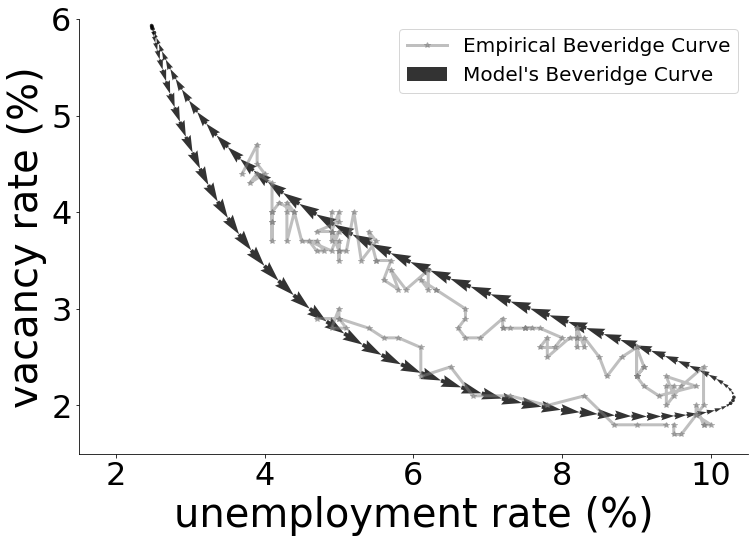

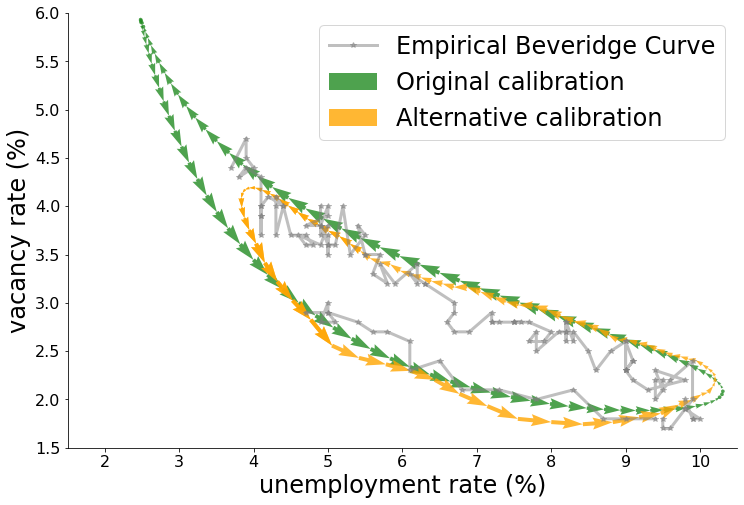

In [9]:

figsize_ = (12,8)
# figsize_ = (18,10)
fontsize_ticks = 32#16
fontsize_axis = 40#26
fontsize_title = 28
fontsize_legend = 20
linewidth_ = 3

path_data = "../data/"
path_exp_sim = "../results/csv/"
path_exp_fig = "../results/fig/"
path_exp_sim = "../results/simulations/"
path_exp_numerics = "../results/csv/"

# details of the simulation, so far hand copied
matrix_omn = "OMN"#"kn"#"JS"#"OMN"#"OMN" #"kn"#"OMN"
matrix_kn = "kn"#"kn"#"JS"#"OMN"#"OMN" #"kn"#"OMN"
matrix = matrix_omn#matrix_omn
#separation rate can be constant of hetero

shock = "beveridgeCurve"

# employment information#ipums_employment2016 = "ipums_employment_2016.csv"
ipums_employment2016 = "ipums_employment_2016.csv"
df_labs_emp = pd.read_csv(path_data+ipums_employment2016)
employment = np.array(df_labs_emp["IPUMS_CPS_av_monthly_employment_whole_period"])
ipums_lab_file = "ipums_variables.csv"
df_labs = pd.read_csv(path_data + ipums_lab_file)

δ_u = 0.016 + 0.00000001 # adding zeros since useful for defining names
δ_v = 0.012 + 0.00000001
γ_u = 10*δ_u
γ_v = γ_u
τ = 3 # time steps after which worker is long-term unemployed
r = 0.5502916755953751
# fraction of labor force with which to run solution (to align with simulation)
diminishing_factor = 1.0

δ_u_gfc = 0.0168001
δ_v_gfc = 0.0074001
γ_u_gfc = 10*δ_u_gfc
γ_v_gfc = 10*δ_u_gfc
τ_gfc = 2
r_gfc = 0.40
amplitude_gfc = 0.46
cycle_period_gfc = lbn.bussiness_cycle_period(τ_gfc)

# shock parameters (cycle amplitude and frequency)
cycle_amp = 0.065
cycle_period = lbn.bussiness_cycle_period(τ)

cycle_freq = cycle_period

parameter_names = "_deltau" + str(δ_u)[3:6] + "v" + str(δ_v)[3:6] + \
    "gamma" + str(γ_u)[2:5] + "_tau" + str(round(τ)) + "_amplitude" + \
    str(cycle_amp)[2:] + "_period" + str(cycle_period) + "_dimfact" + str(diminishing_factor)[2:]

parameter_names_gfc = "_deltau" + str(δ_u_gfc)[3:6] + "v" + str(δ_v_gfc)[3:6] + \
    "gamma" + str(γ_u_gfc)[2:5] + "_tau" + str(round(τ_gfc)) + "_amplitude" + \
    str(amplitude_gfc)[2:] + "_period" + str(cycle_period_gfc) + "_dimfact" + str(diminishing_factor)[2:]

def make_df_num_array(matrix, shock, parameter_names):
    """ returns data frames of numerical solution of unemp, emp,
    longterm unemp and target demand
    """
    df_num_u = pd.read_csv(path_exp_numerics + "u_per_occ_num" + matrix\
                    + shock + parameter_names +  ".csv")
    df_num_e = pd.read_csv(path_exp_numerics + "e_per_occ_num" + matrix\
                    + shock + parameter_names +  ".csv")
    df_num_v = pd.read_csv(path_exp_numerics + "v_per_occ_num" + matrix\
                    + shock + parameter_names +  ".csv")
    df_num_ddagger = pd.read_csv(path_exp_numerics + "ddagger_per_occ_num" + \
                    matrix + shock + parameter_names +  ".csv")
    return df_num_u, df_num_e, df_num_v, df_num_ddagger

def make_u_v_rates(df_num_u, df_num_e, df_num_v):
    un = np.array(df_num_u.iloc[:,3:])
    en = np.array(df_num_e.iloc[:,3:])
    vn= np.array(df_num_v.iloc[:,3:])
    u_total_num = un.sum(axis=0)
    e_total_num = en.sum(axis=0)
    v_total_num = vn.sum(axis=0)
    n_agents_num = un.sum(axis=0)[0] + en.sum(axis=0)[0]

    u_rate = 100*u_total_num/ n_agents_num
    v_rate = 100*v_total_num/ (v_total_num  + e_total_num )
    return u_rate, v_rate


df_num_u_omn, df_num_e_omn, df_num_v_omn, df_num_ddagger_omn = \
        make_df_num_array("OMN", shock, parameter_names)
u_omn, v_omn = make_u_v_rates(df_num_u_omn, df_num_e_omn, df_num_v_omn)

df_num_u_gfc, df_num_e_gfc, df_num_v_gfc, df_num_ddagger_gfc = \
        make_df_num_array("OMN", shock, parameter_names_gfc)
u_gfc, v_gfc = make_u_v_rates(df_num_u_gfc, df_num_e_gfc, df_num_v_gfc)


######
# importing historical bev curve data
######
df_u = pd.read_csv(path_data + "Total_unemployment_BLS1950-2018.csv")
df_v = pd.read_csv(path_data + "vacancy_rateDec2000.csv")
# Start vacancy rate and unemployment rate since Jan 2001
df_v = df_v.iloc[1:]
df_u = df_u.loc[(df_u['Year']>=2001)]
#putting all values of unemployment in a list
list_unemployment = []
#56 since we excluded previous data points
for i in df_u.index:
    list_unemployment = list_unemployment + list(df_u.loc[i][1:].values)
list_vacancies = list(df_v["JobOpenings"])
# Until Sept 2018
list_unemployment =  list_unemployment[:-3]
list_vacancies = list_vacancies[:-2]
assert(len(list_unemployment) == len(list_vacancies))
11, 2.5
list_vacancies[101]
df_v[:20]
df_v[100:120]
# first period is beginning of data set
period0_start = 0
# second period starts in Dec 2001 when first recession ends
period1_start = 11
# third period starts in Dec 2007 when second recession starts
period2_start = 82
# fourth period starts in June 2009 when second recession starts
period3_start = 101
# start of recession due to financial crisis
u_start = list_unemployment[period2_start]
v_start = list_vacancies[period2_start]



######
# Plotting Beveridge Curve in one axis
######
f = plt.figure(figsize=figsize_)
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])
ax1.tick_params(axis='both',labelsize=fontsize_ticks )
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# #plot numerical

ax1.quiver(u_omn[210:210 + cycle_freq-1], v_omn[210:210 + cycle_freq-1], u_omn[210 + 1:210 + cycle_freq ]- \
u_omn[210:210 + cycle_freq-1], v_omn[210 + 1:210 + cycle_freq]-v_omn[210:210 + cycle_freq-1], \
scale_units='xy', angles='xy', scale=1, alpha=0.8, width=0.006, label="Model's Beveridge Curve")
#plt.quiverkey(QV1, 1.2, 0.515, 2, 'arrow 1', coordinates='data')
#
# # #plot simulations
# average_u = np.zeros(t_sim)
# average_v = np.zeros(t_sim)
# for s in range(n_dif_sim):
#     df_us = df_sim_u_list[s]
#     df_vs = df_sim_v_list[s]
#     df_es = df_sim_e_list[s]
#     us = np.array(df_us.iloc[:,3:])
#     es = np.array(df_es.iloc[:,3:])
#     vs = np.array(df_vs.iloc[:,3:])
#     u_total_sim = us.sum(axis=0)
#     e_total_sim = es.sum(axis=0)
#     v_total_sim = vs.sum(axis=0)
#     vac_norm = e_total_sim + v_total_sim
#     #### for vacancy rate need to normalize element-wise
#
#     n_agents = es.sum(axis=0)[0] + us.sum(axis=0)[0]
#     average_u = average_u + u_total_sim / n_agents
#     average_v = average_v + v_total_sim / vac_norm
#     # +1 since num solution is lagged duie to not starting in 0
#     ax1.plot(100*u_total_sim[210+1:210 + cycle_freq+1] / n_agents, 100*v_total_sim[210+1:210 + cycle_freq+1] / vac_norm[210:210 + cycle_freq], color = "forestgreen", alpha=0.2)
#
# ax1.plot(100*average_u[210:210 + cycle_freq], 100*average_v[210:210 + cycle_freq], color="forestgreen", alpha=0.5, linewidth=linewidth_)

# #plot empirical
ax1.plot(list_unemployment[period2_start:period3_start], \
list_vacancies[period2_start:period3_start], "*-", \
label="Empirical Beveridge Curve", alpha = 0.5, color="grey", linewidth=linewidth_)
ax1.plot(list_unemployment[period3_start:], \
list_vacancies[period3_start:], "*-", alpha = 0.5, color="grey", linewidth=linewidth_)
if matrix == "OMN":
    ax1.set_ylim([1.5, 6])
    # ax2.set_xlim([2.5, 10.5])
else:
    ax1.set_ylim([1.5, 7])
    # ax2.set_xlim([2.5, 11])
ax1.set_xlabel("unemployment rate (%)", fontsize=fontsize_axis)
ax1.set_ylabel("vacancy rate (%)", fontsize=fontsize_axis)
# ax2.set_ylim([1.5, 10.5])
# ax2.set_xlim([1.5, 10.5])
ax1.set_ylim([1.5, 6])
ax1.set_xlim([1.5, 10.5])
plt.legend(fontsize=fontsize_legend)
# plt.savefig(path_exp_fig+"BeveridgeCurveMatchingArrows_"+ shock + matrix + parameter_names + ".svg", bbox_inches="tight")
plt.show()


######
# Plotting Beveridge Curve in one axis
######
fontsize_ticks = 16
fontsize_axis = 24
fontsize_title = 28
fontsize_legend = 24
linewidth_ = 3

f = plt.figure(figsize=figsize_)
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])
ax1.tick_params(axis='both',labelsize=fontsize_ticks )
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# #plot numerical

ax1.quiver(u_omn[210:210 + cycle_freq-1], v_omn[210:210 + cycle_freq-1], u_omn[210 + 1:210 + cycle_freq ]- \
u_omn[210:210 + cycle_freq-1], v_omn[210 + 1:210 + cycle_freq]-v_omn[210:210 + cycle_freq-1], \
scale_units='xy', angles='xy', scale=1, alpha=0.8, width=0.006, label="Original calibration", color="forestgreen")

ax1.quiver(u_gfc[210:210 + cycle_freq-1], v_gfc[210:210 + cycle_freq-1], u_gfc[210 + 1:210 + cycle_freq ]- \
u_gfc[210:210 + cycle_freq-1], v_gfc[210 + 1:210 + cycle_freq]-v_gfc[210:210 + cycle_freq-1], \
scale_units='xy', angles='xy', scale=1, alpha=0.8, width=0.006, label="Alternative calibration", color="orange")

# #plot empirical
ax1.plot(list_unemployment[period2_start:period3_start], \
list_vacancies[period2_start:period3_start], "*-", \
label="Empirical Beveridge Curve", alpha = 0.5, color="grey", linewidth=linewidth_)
ax1.plot(list_unemployment[period3_start:], \
list_vacancies[period3_start:], "*-", alpha = 0.5, color="grey", linewidth=linewidth_)
if matrix == "OMN":
    ax1.set_ylim([1.5, 6])
    # ax2.set_xlim([2.5, 10.5])
else:
    ax1.set_ylim([1.5, 7])
    # ax2.set_xlim([2.5, 11])
ax1.set_xlabel("unemployment rate (%)", fontsize=fontsize_axis)
ax1.set_ylabel("vacancy rate (%)", fontsize=fontsize_axis)
# ax2.set_ylim([1.5, 10.5])
# ax2.set_xlim([1.5, 10.5])
ax1.set_ylim([1.5, 6])
ax1.set_xlim([1.5, 10.5])
plt.legend(fontsize=fontsize_legend)
# plt.savefig(path_exp_fig+"BeveridgeCurveMatchingArrows_" + "bothshocks" + \
#             matrix + parameter_names + ".svg", bbox_inches="tight")
# plt.savefig(path_exp_fig+"BeveridgeCurveMatchingArrows_" + "bothshocks" + \
#             matrix + parameter_names + ".png", bbox_inches="tight")
plt.show()
